In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from tqdm import tqdm

import qulacs
from qulacs import QuantumState, QuantumCircuit
from qulacs.gate import CZ, RX, RY, RZ, merge
from qulacs import Observable
from qulacs.observable import create_observable_from_openfermion_text
from qulacsvis import circuit_drawer
from openfermion.transforms import get_fermion_operator, jordan_wigner
from openfermion.linalg import get_sparse_operator
from openfermion.chem import MolecularData
from openfermionpyscf import run_pyscf
from pyscf import fci

In [2]:
basis = "sto-3g"
multiplicity = 1
charge = 0
distance  = 0.74
geometry = [["H", [0,0,0]],["H", [0,0,distance]]]
description  = "tmp"
molecule = MolecularData(geometry, basis, multiplicity, charge, description)
molecule = run_pyscf(molecule,run_scf=1,run_fci=1)
n_qubit = molecule.n_qubits
n_electron = molecule.n_electrons
fermionic_hamiltonian = get_fermion_operator(molecule.get_molecular_hamiltonian())
jw_hamiltonian = jordan_wigner(fermionic_hamiltonian)
qulacs_hamiltonian = create_observable_from_openfermion_text(str(jw_hamiltonian))

### Ansatz

Reference: A. Kandala _et. al._ , “Hardware-efficient variational quantum eigensolver for small molecules and quantum magnets“, Nature **549**, 242–246)

In [3]:
depth = n_qubit

def he_ansatz_circuit(n_qubit, depth, theta_list):
    circuit = QuantumCircuit(n_qubit)
    for i in range(n_qubit):
        circuit.add_gate(merge(RX(i, theta_list[2*i+3*n_qubit*depth]), RZ(i, theta_list[2*i+1+3*n_qubit*depth])))
    for d in range(depth):
        for i in range(n_qubit//2):
            circuit.add_gate(CZ(2*i, 2*i+1))
        for i in range(n_qubit//2-1):
            circuit.add_gate(CZ(2*i+1, 2*i+2))
        for i in range(n_qubit):
            circuit.add_gate(merge(merge(RZ(i, theta_list[2*i+3*n_qubit*d]), RX(i, theta_list[2*i+1+3*n_qubit*d])),RZ(i, theta_list[2*i+3*n_qubit*d])))
    
    return circuit

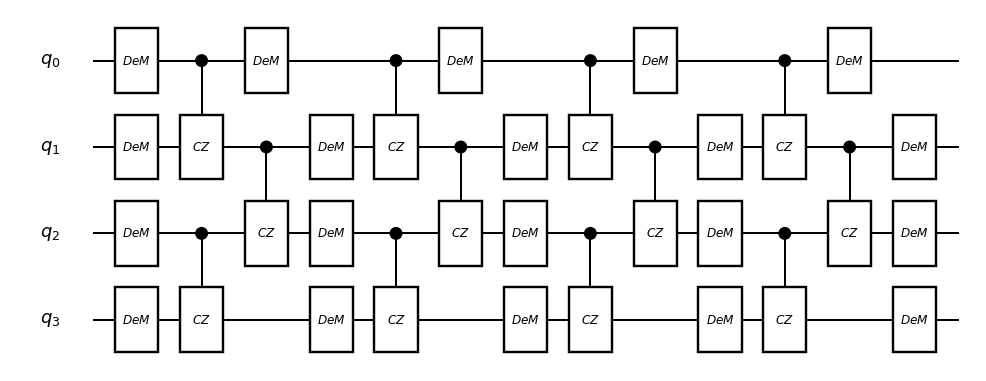

In [4]:
theta_list_test = 2*np.pi*np.random.random(3*n_qubit*depth+2*n_qubit)
circuit_drawer(he_ansatz_circuit(n_qubit, depth, theta_list_test), "mpl")

In [5]:
def cost(theta_list):
    state = QuantumState(n_qubit)
    circuit = he_ansatz_circuit(n_qubit, depth, theta_list)
    circuit.update_quantum_state(state)
    return qulacs_hamiltonian.get_expectation_value(state)

In [6]:
cost_history = []
init_theta_list = 2*np.pi*np.random.random(3*n_qubit*depth+2*n_qubit)
cost_history.append(cost(init_theta_list))
method = "BFGS"
opt = minimize(cost, init_theta_list,
               method=method,
               callback=lambda x: cost_history.append(cost(x)))

print(opt.fun)

-1.13728322454759


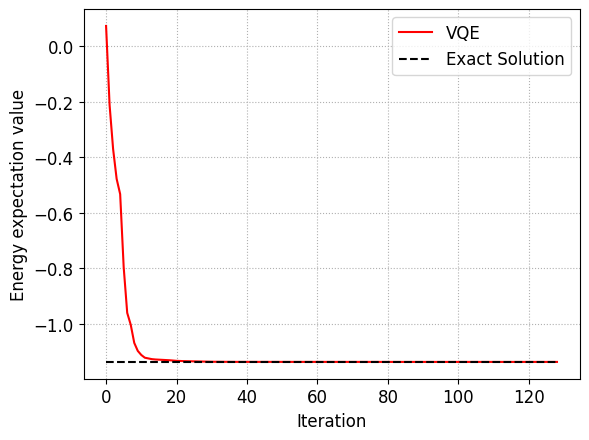

In [12]:
plt.rcParams["font.size"] = 12
plt.plot(cost_history, color="red", label="VQE")
plt.plot(range(len(cost_history)), [molecule.fci_energy]*len(cost_history), linestyle="dashed", color="black", label="Exact Solution")
plt.xlabel("Iteration")
plt.ylabel("Energy expectation value")
plt.grid(linestyle='dotted')
plt.legend()
plt.show()

In [115]:
#number = 41
#r_initial = 0.3
#r_final = 2.5
number = 41
r_initial = 0.165
r_final = 4.0
r_list = []
energies = []
depth = 4

method = "BFGS"
#options = {"disp": True, "gtol": 1e-6}

init_theta_list = 2*np.pi*np.random.random(3*n_qubit*depth+2*n_qubit)

for i in tqdm(range(number)):
    r = r_initial+i*(r_final-r_initial)/(number-1)
    geometry = [["H", [0,0,0]],["H", [0,0,r]]]
    molecule = MolecularData(geometry, basis, multiplicity, charge, description)
    molecule = run_pyscf(molecule,run_scf=1,run_fci=1)
    fermionic_hamiltonian = get_fermion_operator(molecule.get_molecular_hamiltonian())
    jw_hamiltonian = jordan_wigner(fermionic_hamiltonian)
    qulacs_hamiltonian = create_observable_from_openfermion_text(str(jw_hamiltonian))

    def cost(theta_list):        
        state = QuantumState(n_qubit)
        circuit = he_ansatz_circuit(n_qubit, depth, theta_list)
        circuit.update_quantum_state(state)
        return qulacs_hamiltonian.get_expectation_value(state)
    
    opt = minimize(cost, init_theta_list, method=method)

    r_list.append(r)
    energies.append(opt.fun)

100%|██████████| 41/41 [03:28<00:00,  5.09s/it]


In [116]:
r_min = 0
E_min = 0
index = 0

for j in range(len(energies)):
    if energies[j] < E_min:
        r_min = r_list[j]
        E_min = energies[j]
        index = j

print(r_min)
print(E_min)
print(index)

0.74025
-1.1372816268327128
6


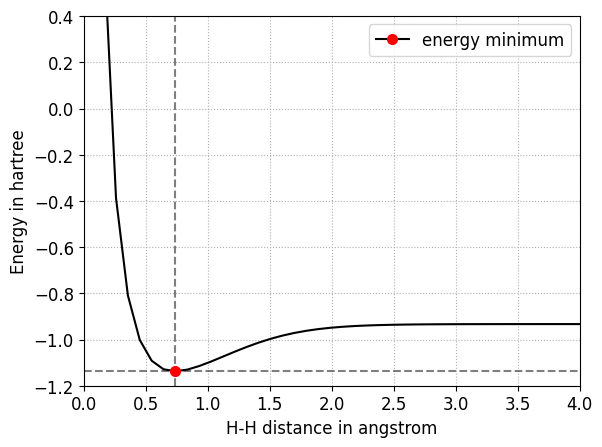

In [117]:
xmin_plot, xmax_plot = 0, 4
ymin_plot, ymax_plot = -1.2, 0.4
plt.xlim(xmin_plot, xmax_plot)
plt.ylim(ymin_plot, ymax_plot)

plt.axvline(r_min, color="black", linestyle="dashed", alpha=0.5)
plt.axhline(E_min, color="black", linestyle="dashed", alpha=0.5)

plt.plot(r_list, energies, color="black", linestyle="solid")
plt.plot(r_min, E_min, color="black", marker="o", markersize=7, markeredgecolor="red", markerfacecolor="red", label="energy minimum")

plt.ylabel("Energy in hartree")
plt.xlabel("H-H distance in angstrom")
plt.grid(linestyle='dotted')
plt.legend()
plt.show()